In [1]:
import pandas as pd 

In [2]:
rename_dict = {
    "일시": "날짜",
    "평균기온(°C)": "평균 기온",
    "최저기온(°C)": "최저 기온",
    "최고기온(°C)": "최고 기온",
    "일강수량(mm)": "강수량",
    "평균 풍속(m/s)": "풍속",
    "평균 상대습도(%)": "습도",
    "일 최심적설(cm)": "적설량"
}

In [3]:
df = pd.read_csv("./weather_csv/weather_raw_data.csv", encoding="cp949").rename(columns=rename_dict)

In [4]:
# 날짜 및 수치형 처리
df["날짜"] = pd.to_datetime(df["날짜"], errors="coerce")
for col in ["평균 기온", "최저 기온", "최고 기온", "강수량", "풍속", "습도", "적설량"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

In [5]:
# 결측치 처리
df["강수량"] = df['강수량'].fillna(0)
df['적설량'] = df['적설량'].fillna(0)

In [6]:
# 파생변수 생성
df["기온 범위"] = df["최고 기온"] - df["최저 기온"]
df["습도 대비 강수량"] = df["강수량"] / (df["습도"] + 1)  # 0으로 나누는 것 방지
df["불쾌지수"] = df["풍속"] * df["습도"]
df["건조지수"] = df["풍속"] / (df["습도"] + 1)  # 0으로 나누는 것 방지


In [7]:
region_map = {
    # 강원도
    "강릉": "강원도", "대관령": "강원도", "동해": "강원도", "북강릉": "강원도",
    "북춘천": "강원도", "삼척": "강원도", "속초": "강원도", "영월": "강원도",
    "원주": "강원도", "인제": "강원도", "정선군": "강원도", "철원": "강원도",
    "춘천": "강원도", "태백": "강원도", "홍천": "강원도",

    # 경기
    "동두천": "경기", "수원": "경기", "양평": "경기", "이천": "경기", "파주": "경기",

    # 경남
    "거제": "경남", "거창": "경남", "김해시": "경남", "남해": "경남", "밀양": "경남",
    "북창원": "경남", "산청": "경남", "양산시": "경남", "의령군": "경남", "진주": "경남",
    "창원": "경남", "통영": "경남", "함양군": "경남", "합천": "경남",

    # 경북
    "경주시": "경북", "구미": "경북", "문경": "경북", "봉화": "경북", "상주": "경북",
    "안동": "경북", "영덕": "경북", "영주": "경북", "영천": "경북", "울릉도": "경북",
    "울진": "경북", "의성": "경북", "청송군": "경북", "포항": "경북",

    # 광역시 및 특별시
    "광주": "광주", "대구": "대구", "대전": "대전",
    "부산": "부산", "북부산": "부산", "서울": "서울",
    "세종": "세종", "울산": "울산", "강화": "인천", "백령도": "인천", "인천": "인천",

    # 전남
    "강진군": "전남", "고흥": "전남", "광양시": "전남", "목포": "전남", "무안": "전남",
    "보성군": "전남", "순천": "전남", "여수": "전남", "영광군": "전남", "완도": "전남",
    "장흥": "전남", "주암": "전남", "진도군": "전남", "해남": "전남", "흑산도": "전남",

    # 전북
    "고창": "전북", "고창군": "전북", "군산": "전북", "남원": "전북", "부안": "전북",
    "순창군": "전북", "임실": "전북", "장수": "전북", "전주": "전북", "정읍": "전북",

    # 제주
    "고산": "제주도", "서귀포": "제주도", "성산": "제주도", "제주": "제주도",

    # 충남
    "금산": "충남", "보령": "충남", "부여": "충남", "서산": "충남", "천안": "충남", "홍성": "충남",

    # 충북
    "보은": "충북", "서청주": "충북", "제천": "충북", "청주": "충북", "추풍령": "충북", "충주": "충북"
}


In [8]:
df["지역"] = df["지점명"].map(region_map)

In [9]:
# 지점, 지점명 제거 및 지역 맨앞으로
df = df.drop(columns=['지점', '지점명'])
cols = ['지역'] + [col for col in df.columns if col != '지역']
df = df[cols]

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns
import platform 

# 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'  
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'    
else:
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False

##### 지역별 기후 클러스터링 결과
KMeans 알고리즘으로 지역 기후를 평균기온과 습도 기준으로 클러스터링한 결과
- 해석 예시
    - Cluster 0 (주황색): 평균 기온 가장 높고, 습도는 중간 수준의 지역 → 한국에서 기온이 가장 높고 특이한 기후를 가진 지역
    - Cluster 1 (연두색): 기온 중상~중간, 습도는 낮은 지역 → 상대적으로 따뜻하고 건조한 특성을 가진 지역
    - Cluster 2 (파란색): 평균 기온 낮고, 습도는 높은 지역 → 서늘하고 습한 지역

- 분석 예시
    - 지역별 이상기후 탐지 → 한 클러스터에서 벗어나면 이상 기후 의심 가능
    - 행정구역 재편 고려 → 기후 특성 기반 군집으로 행정구역 묶기
    - 기후 정책 지역별 구분 → 습도/기온 특성에 따라 냉방/난방 정책 차등 가능

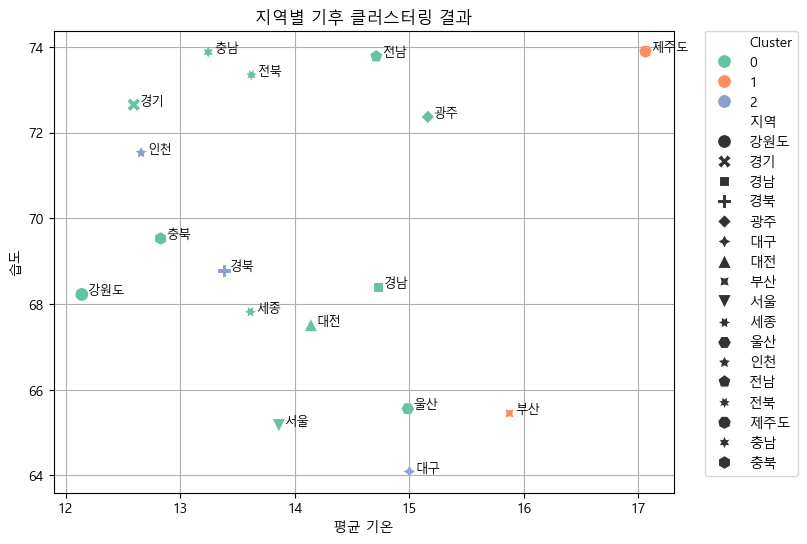

In [15]:
# 1. 날짜 파싱 및 연도 추출
df['연도'] = pd.to_datetime(df['날짜']).dt.year

# 2. 연도 필터링 (2015~2024)
df_filtered = df[df['연도'].between(2015, 2024)]

# 3. 지역 + 연도별 기후 평균 집계
agg_features = ['평균 기온', '최저 기온', '최고 기온', '강수량', '풍속', '습도', '적설량', '기온 범위', '습도 대비 강수량', '불쾌지수', '건조지수']
grouped = df_filtered.groupby(['지역'])[agg_features].mean().reset_index()

# 4. 정규화 (스케일링)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(grouped[agg_features])

# 5. 군집 모델 학습 (GMM)
#kmeans = KMeans(n_clusters=3, random_state=42)
#grouped['Cluster'] = kmeans.fit_predict(X_scaled)

gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X_scaled)
# labels = gmm.predict(X_scaled)
grouped['Cluster'] = gmm.predict(X_scaled)

# 6. 시각화 (예: 평균 기온 vs 습도)
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=grouped,
    x='평균 기온', 
    y='습도',
    hue='Cluster', 
    style='지역',
    palette='Set2',
    s=100
)

# 각 점에 지역 이름 붙이기
for i in range(len(grouped)):
    plt.text(
        grouped['평균 기온'][i] + 0.05,  # 약간 오른쪽으로
        grouped['습도'][i], 
        grouped['지역'][i], 
        fontsize=9
    )
    
plt.title("지역별 기후 클러스터링 결과")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.show()
